# Soil Fertility Prediction using Random Forest on Synthetic Data

This notebook demonstrates the process of building and evaluating a Random Forest model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe). Unlike the original notebook, this one uses the synthetic dataset generated to match the statistical properties of the original data.

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import joblib

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore Data

In [2]:
# Load the synthetic dataset
df = pd.read_csv('../Datasets/synthetic_dataset.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# Check class distribution
print("\nClass Distribution:")
print(df['Output'].value_counts(normalize=True))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       1005 non-null   int64  
 1   P       1005 non-null   float64
 2   K       1005 non-null   int64  
 3   EC      1005 non-null   float64
 4   Fe      1005 non-null   float64
 5   Output  1005 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 47.2 KB
None

First few rows:
     N     P    K   EC   Fe  Output
0  104   8.8  528  0.5  0.9       1
1  274   5.5  413  0.5  2.7       1
2  307  10.8  488  0.3  1.0       1
3  247  13.2  494  0.5  5.6       1
4  251   8.4  417  0.6  3.8       0

Summary statistics:
                 N            P            K           EC           Fe  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1005.000000   
mean    248.254726    13.816219   500.906468     0.533035     4.053134   
std      74.041100    19.923868   120.498711     0.1

## 3. Data Visualization

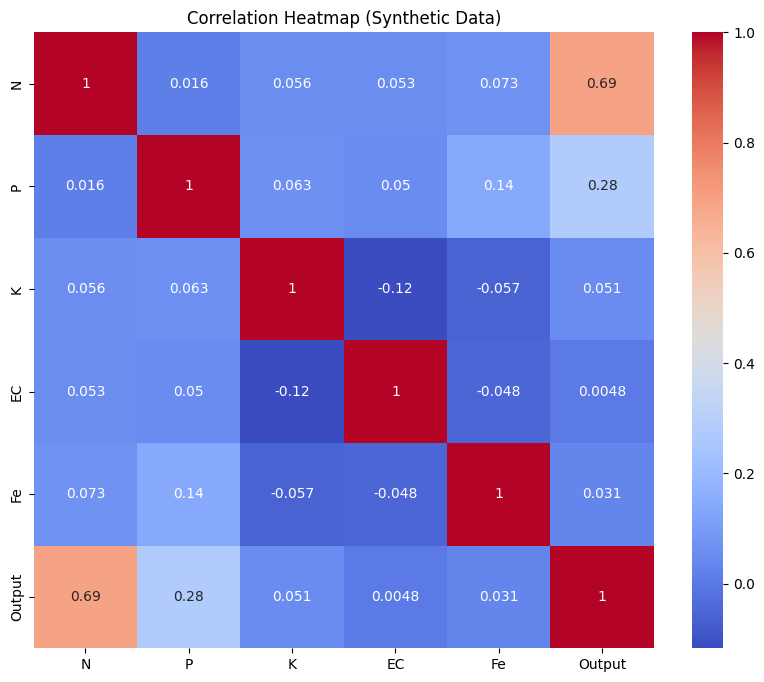

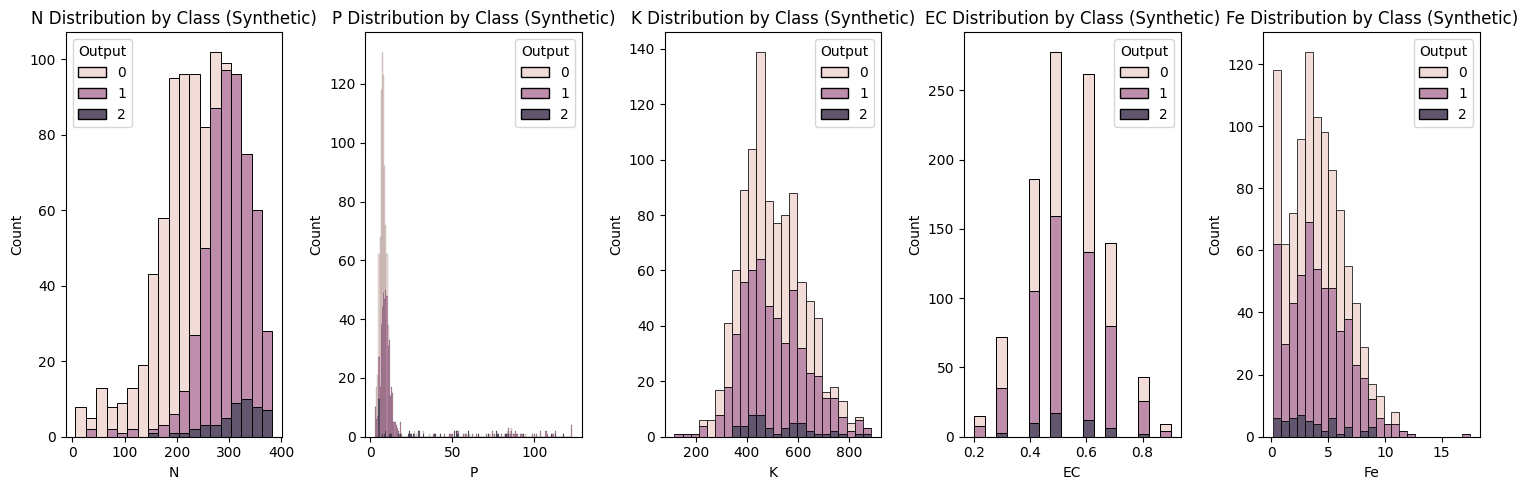

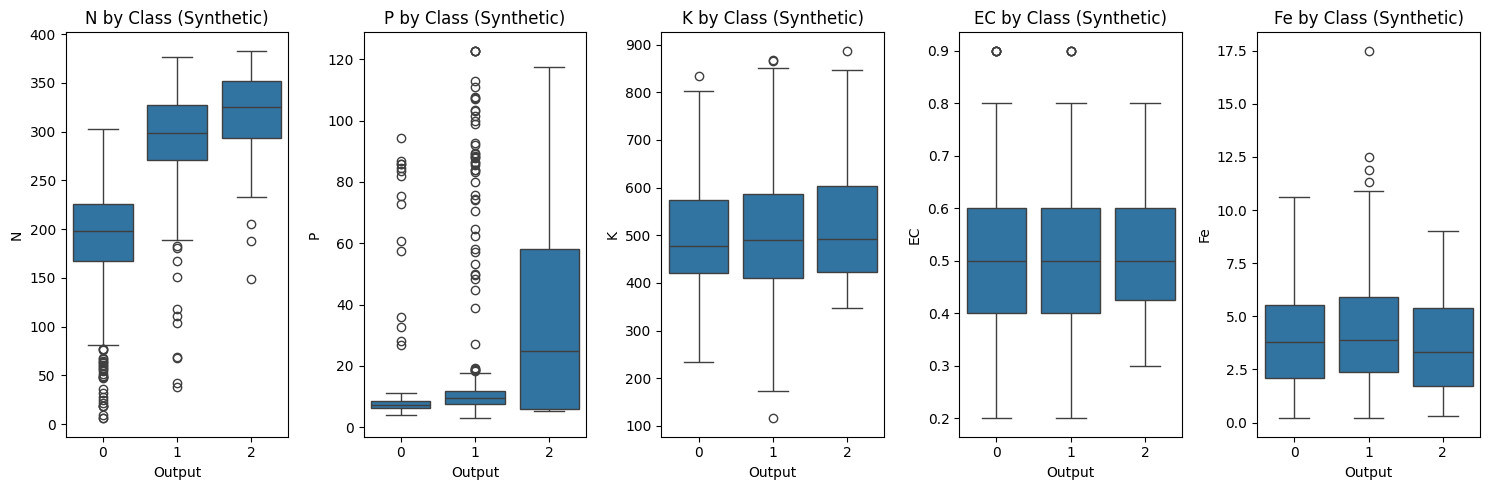

In [3]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Synthetic Data)')
plt.show()

# Distribution plots
plt.figure(figsize=(15, 5))
for i, column in enumerate(df.drop('Output', axis=1).columns, 1):
    plt.subplot(1, 5, i)
    sns.histplot(data=df, x=column, hue='Output', multiple="stack")
    plt.title(f'{column} Distribution by Class (Synthetic)')
plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(15, 5))
for i, column in enumerate(df.drop('Output', axis=1).columns, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=df, x='Output', y=column)
    plt.title(f'{column} by Class (Synthetic)')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [4]:
# Separate features and target
X = df.drop('Output', axis=1)
y = df['Output']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initial model evaluation with cross-validation
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation scores: [0.91304348 0.86335404 0.91304348 0.9068323  0.90625   ]
Average CV score: 0.9005 (+/- 0.0376)


## 5. Model Training and Optimization

In [5]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.9067468944099378


## 6. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        91
           1       0.91      0.95      0.93       100
           2       1.00      0.40      0.57        10

    accuracy                           0.93       201
   macro avg       0.95      0.77      0.82       201
weighted avg       0.93      0.93      0.92       201



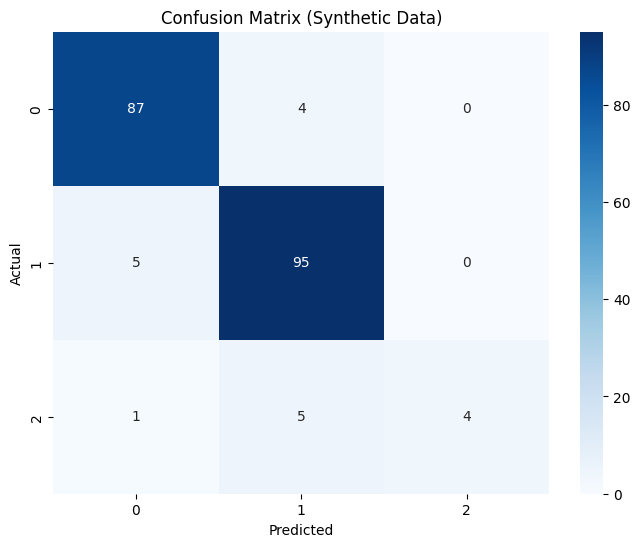

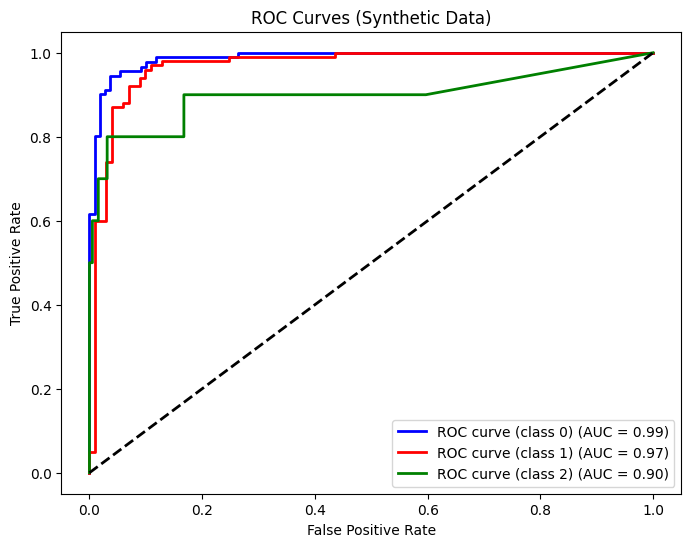

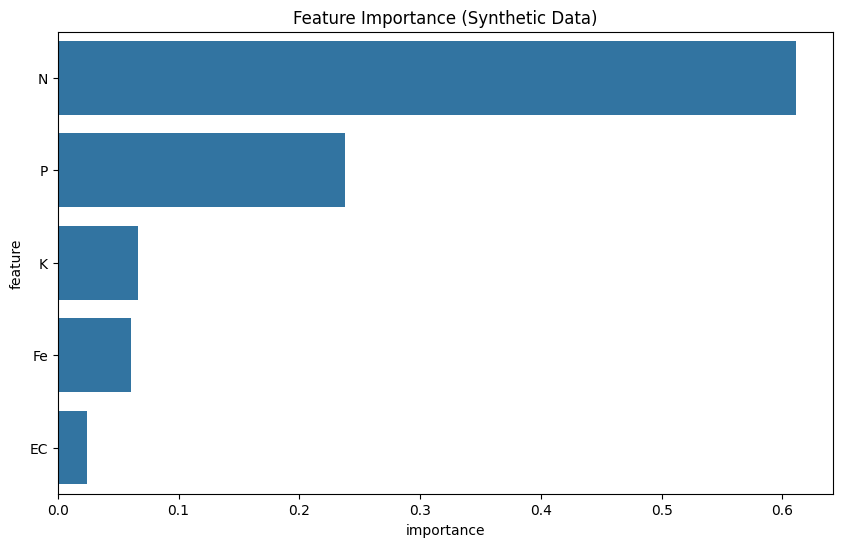


Feature Importance:
  feature  importance
0       N    0.611172
1       P    0.238215
2       K    0.066167
4      Fe    0.060628
3      EC    0.023819


In [6]:
# Make predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Synthetic Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curves
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Synthetic Data)')
plt.legend(loc='lower right')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Synthetic Data)')
plt.show()

print("\nFeature Importance:")
print(feature_importance)

## 7. Learning Curves

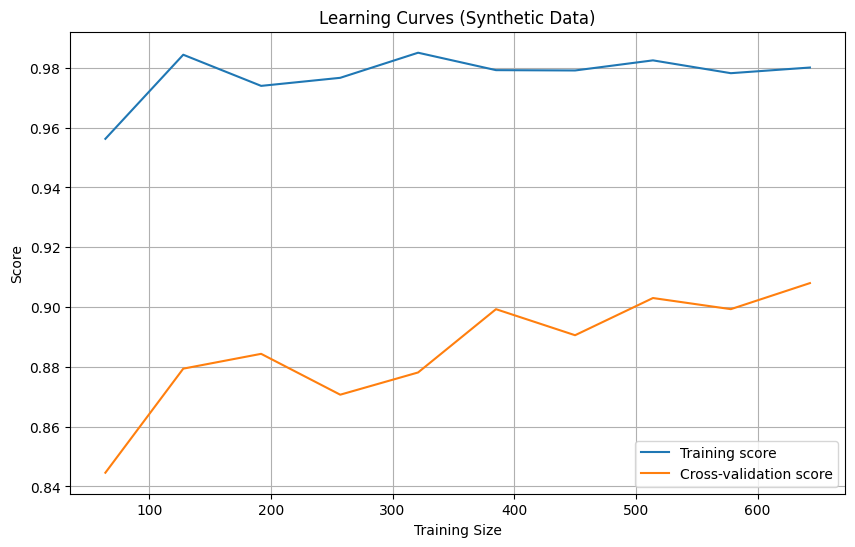

In [7]:
# Plot learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves (Synthetic Data)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 8. Save Model

In [8]:
# Save the model and scaler
joblib.dump(best_rf, 'trained_models/rf_classifier_synthetic.pkl')
joblib.dump(scaler, 'trained_models/rf_scaler_synthetic.pkl')
feature_importance.to_csv('trained_models/rf_feature_importance_synthetic.csv', index=False)

print("Model, scaler, and feature importance have been saved.")

# Example prediction
sample_input = pd.DataFrame({
    'N': [200],
    'P': [8.0],
    'K': [500],
    'EC': [0.5],
    'Fe': [0.6]
})

# Scale the input
sample_scaled = scaler.transform(sample_input)

# Make prediction
prediction = best_rf.predict(sample_scaled)
probabilities = best_rf.predict_proba(sample_scaled)

print("\nExample Prediction:")
print("Input Features:")
print(sample_input)
print("\nPredicted Class:", prediction[0])
print("\nClass Probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i}: {prob:.4f}")

Model, scaler, and feature importance have been saved.

Example Prediction:
Input Features:
     N    P    K   EC   Fe
0  200  8.0  500  0.5  0.6

Predicted Class: 0

Class Probabilities:
Class 0: 0.9205
Class 1: 0.0795
Class 2: 0.0000
